In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Load World Bank Indicators Data
file_path = '/content/world_bank_common_indicators.csv'  # Adjust path if needed
df = pd.read_csv(file_path)

# Melt to long format
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
value_vars = [col for col in df.columns if 'YR' in col]

df_long = df.melt(id_vars=id_vars, value_vars=value_vars,
                  var_name='Year', value_name='Value')
df_long['Year'] = df_long['Year'].str.extract('(\d+)').astype(int)


In [ ]:
india_df = df_long[df_long['Country Name'] == 'India']


In [ ]:
pivot_df = india_df.pivot(index='Year', columns='Series Code', values='Value')
pivot_df = pivot_df.sort_index()
pivot_df.fillna(method='ffill', inplace=True)  # Forward fill missing values
pivot_df.fillna(0, inplace=True)               # Fill remaining NaNs with 0


<ipython-input-16-1344695443>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
indicators_of_interest = [
    'NY.GDP.PCAP.CD',   # GDP per capita (current US$)
    'SP.POP.TOTL',     # Total population
    'SE.ADT.LITR.ZS'   # Literacy rate
]

existing_indicators = [ind for ind in indicators_of_interest if ind in pivot_df.columns]
print("Available indicators:", existing_indicators)


Available indicators: ['NY.GDP.PCAP.CD', 'SP.POP.TOTL']


Change points for NY.GDP.PCAP.CD: [1964, 1969, 1974, 1979, 1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2024]


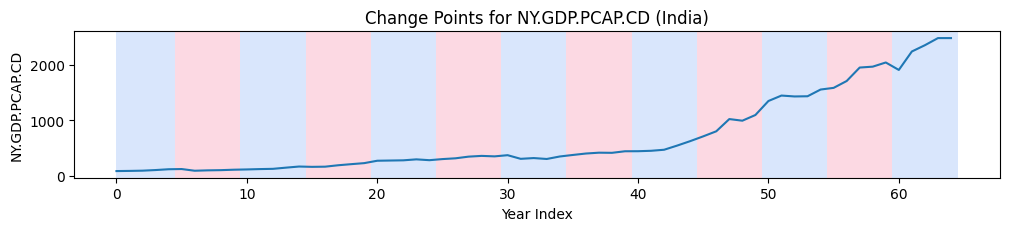

Change points for SP.POP.TOTL: [1964, 1969, 1974, 1979, 1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2024]


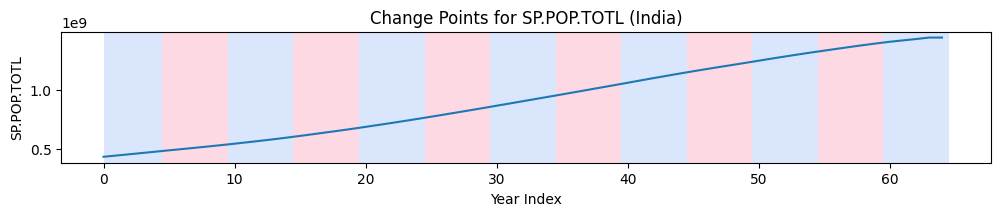

In [ ]:
def detect_change_points(series, model="l2", penalty=3):
    series = series[~np.isnan(series)]
    algo = rpt.Pelt(model=model).fit(series)
    result = algo.predict(pen=penalty)
    return result

year_list = pivot_df.index.tolist()

for indicator in existing_indicators:
    series = pivot_df[indicator].values
    cps = detect_change_points(series)
    cp_years = [year_list[cp - 1] for cp in cps if cp - 1 < len(year_list)]

    print(f"Change points for {indicator}: {cp_years}")

    rpt.display(series, cps)
    plt.title(f"Change Points for {indicator} (India)")
    plt.xlabel('Year Index')
    plt.ylabel(indicator)
    plt.show()


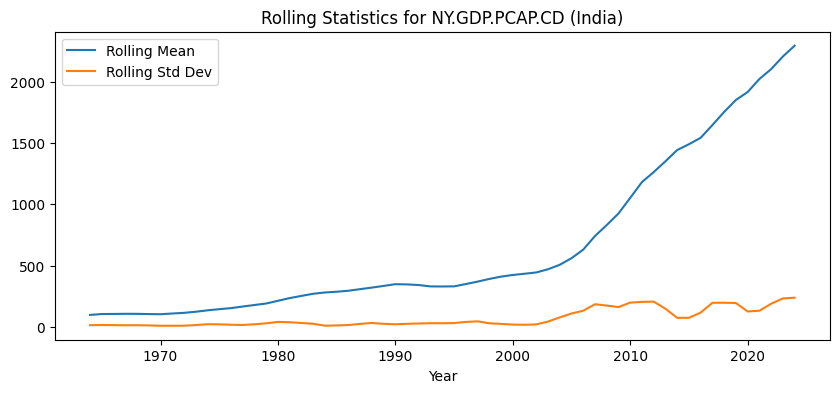

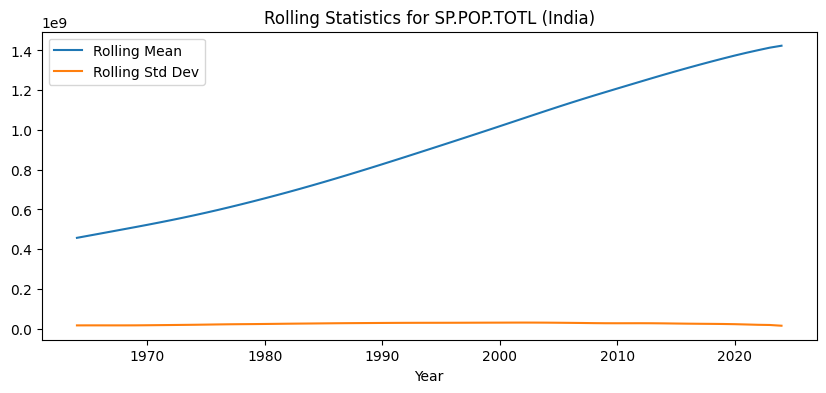

In [ ]:
window_size = 5  # 5-year rolling window

for indicator in existing_indicators:
    plt.figure(figsize=(10, 4))
    pivot_df[indicator].rolling(window=window_size).mean().plot(label='Rolling Mean')
    pivot_df[indicator].rolling(window=window_size).std().plot(label='Rolling Std Dev')
    plt.title(f'Rolling Statistics for {indicator} (India)')
    plt.legend()
    plt.show()


In [ ]:
# Create label column for each change detected
labels_df = pd.DataFrame(index=pivot_df.index)

for indicator in existing_indicators:
    series = pivot_df[indicator].values
    cps = detect_change_points(series)
    cp_years = [year_list[cp - 1] for cp in cps if cp - 1 < len(year_list)]
    labels_df[indicator+'_change'] = [1 if year in cp_years else 0 for year in labels_df.index]

labels_df.head()


,NY.GDP.PCAP.CD_change,SP.POP.TOTL_change
Year,,
1960,0,0
1961,0,0
1962,0,0
1963,0,0
1964,1,1


In [ ]:
# Example: Forecast GDP per capita
feature = 'NY.GDP.PCAP.CD'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivot_df[[feature]])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(scaled_data, seq_length)

# LSTM expects input shape: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X, y, epochs=200, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1619
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1502
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1346 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1042 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1138
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1076
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0943
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0905
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0927 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0774
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0684
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0644
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0554
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0456
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0399
Epoch 16/200
2/

In [ ]:
# Forecast next year
last_seq = scaled_data[-seq_length:]
last_seq = last_seq.reshape((1, seq_length, 1))
forecast = model.predict(last_seq)
forecast_inversed = scaler.inverse_transform(forecast)
print(f"Forecasted GDP per capita for {pivot_df.index[-1]+1}: {forecast_inversed[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
Forecasted GDP per capita for 2025: 2619.46142578125


In [ ]:
# Train-Test Split (80-20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - seq_length:]  # Include sequence overlap


In [ ]:
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
y_pred = model.predict(X_test)

# Inverse transform to get original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R2 Score: {r2}")


Test MSE: 8586.201969459995
Test MAE: 75.9893585150081
Test R2 Score: 0.9345062260815752


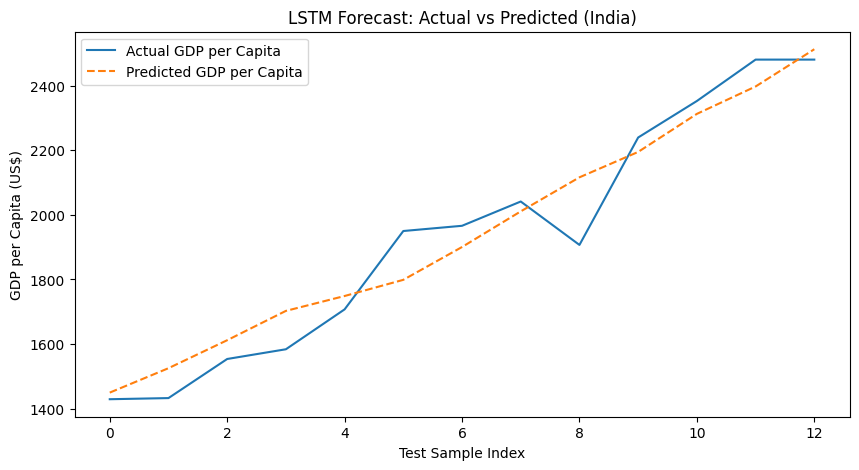

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Actual GDP per Capita')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicted GDP per Capita', linestyle='--')
plt.title('LSTM Forecast: Actual vs Predicted (India)')
plt.xlabel('Test Sample Index')
plt.ylabel('GDP per Capita (US$)')
plt.legend()
plt.show()
